## Data Exploration with Gensim

Load Standards:

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
import itertools
import json
import pickle
import gensim

#### Load additional:

In [2]:
import itertools
import collections
import json
import pickle
import nltk
import gensim

Instantiate spark: (note this will only work after vagrant is up):

In [7]:
import os
import findspark
findspark.init()
print findspark.find()
import pyspark
conf = (pyspark.SparkConf()
    .setMaster('local[4]')
    .setAppName('pyspark')
    .set("spark.executor.memory", "2g"))
sc = pyspark.SparkContext(conf=conf)
sc._conf.getAll()


/home/vagrant/spark


[(u'spark.executor.memory', u'2g'),
 (u'spark.master', u'local[4]'),
 (u'spark.rdd.compress', u'True'),
 (u'spark.serializer.objectStreamReset', u'100'),
 (u'spark.submit.deployMode', u'client'),
 (u'spark.app.name', u'pyspark')]

In [8]:
import sys
rdd = sc.parallelize(xrange(10),10)
rdd.map(lambda x: sys.version).collect()

['2.7.10 |Anaconda 2.3.0 (64-bit)| (default, May 28 2015, 17:02:03) \n[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]',
 '2.7.10 |Anaconda 2.3.0 (64-bit)| (default, May 28 2015, 17:02:03) \n[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]',
 '2.7.10 |Anaconda 2.3.0 (64-bit)| (default, May 28 2015, 17:02:03) \n[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]',
 '2.7.10 |Anaconda 2.3.0 (64-bit)| (default, May 28 2015, 17:02:03) \n[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]',
 '2.7.10 |Anaconda 2.3.0 (64-bit)| (default, May 28 2015, 17:02:03) \n[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]',
 '2.7.10 |Anaconda 2.3.0 (64-bit)| (default, May 28 2015, 17:02:03) \n[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]',
 '2.7.10 |Anaconda 2.3.0 (64-bit)| (default, May 28 2015, 17:02:03) \n[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]',
 '2.7.10 |Anaconda 2.3.0 (64-bit)| (default, May 28 2015, 17:02:03) \n[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]',
 '2.7.10 |Anaconda 2.3.0 (64-bit)| (default, May 28 2015, 17:02:03) \n[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]',
 

Open everything that's been saved in /data/conditioned

In [322]:
# Open everything that's been saved in /data/conditioned

df=pd.read_csv("../../data/conditioned/use-this-master-lyricsdf-extracted.csv")
dfg=pd.read_csv("../../data/conditioned/master-lyricsdf-genre_inner.csv")

with open("../../data/conditioned/noun-n-gram.json") as json_file:
    noungram = json.load(json_file)
with open("../../data/conditioned/nounvocab.json") as json_file:
    nounvocab = json.load(json_file)
with open("../../data/conditioned/nounid2word.json") as json_file:
    nounid2word = json.load(json_file)
with open("../../data/conditioned/adj-n-gram.json") as json_file:
    adjgram = json.load(json_file)
with open("../../data/conditioned/adjvocab.json") as json_file:
    adjvocab = json.load(json_file)
with open("../../data/conditioned/adjid2word.json") as json_file:
    adjvocab = json.load(json_file)
with open("../../data/conditioned/decade-dict.json") as json_file:
    decade_dict = json.load(json_file)
    

f = open("../../data/conditioned/ahypes.p",'r')  
ahypes = pickle.load(f)  
f = open("../../data/conditioned/nhypes.p",'r')  
nhypes = pickle.load(f)
f = open("../../data/conditioned/corpus.p",'r')  
corpus = pickle.load(f)


df.head(3)

,index,position,year,title.href,title,artist,lyrics,decade,song_key,lyrics_url,lyrics_abstract
0,0,1,1970,https://en.wikipedia.org/wiki/Bridge_over_Trou...,Bridge over Troubled Water,Simon and Garfunkel,When you're weary. Feeling small. When tears a...,1970,1970-1,http://lyrics.wikia.com/Simon_And_Garfunkel:Br...,When you're weary. Feeling small. When tears a...
1,1,2,1970,https://en.wikipedia.org/wiki/(They_Long_to_Be...,(They Long to Be) Close to You,The Carpenters,Why do birds suddenly appear. Everytime you ar...,1970,1970-2,http://lyrics.wikia.com/Carpenters:%28They_Lon...,Why do birds suddenly appear. Everytime you ar...
2,2,3,1970,https://en.wikipedia.org/wiki/American_Woman_(...,American Woman,The Guess Who,"Mmm, da da da. Mmm, mmm, da da da. Mmm, mmm, d...",1970,1970-3,http://lyrics.wikia.com/The_Guess_Who:American...,"Mmm, da da da. Mmm, mmm, da da da. Mmm, mmm, d..."


## Low Hanging Fruit- Descriptive Statistics
### Across the Database and Partitioned By Genre and Decade
- word counts
- song length
- lexical diversity
- repetition count

Stored in JSON objects suitable for visualizations


In [306]:
decades=df.decade.unique()
df.shape, dfg.shape

((4500, 11), (2946, 316))

## Repetition of Words Within Songs

Repetition of words or phrases is a frequently used design element in music lyrics. Comparison of text analysis of lyrics to text analysis of prose could therefore be uninformative or even misleading. While this subject alone could merit extensive study, at the point we make some effort to quantify the degree of repetition contained in each song by calculating its lexical diversity using NLTK, as described in Bird,Klein, and Loper [Natural Language Processing with Python](http://www.nltk.org/book/). A column for lexical diversity is added to each row of the dataframe.  

In [490]:
# eliminate " We don't currently have a license"
counter=0
#eliminate rows with null lyrics
dfc = df[pd.isnull(df.lyrics)==False]


for row in dfc.iterrows():
    if row[1][6].startswith("We don't currently have a license"):
        dfc.iloc[row[1][1],6]="Instrumental"
    counter+=1
    if counter >3000:
        break


#eliminate instrumentals
dfc = dfc[df.lyrics!="Instrumental"]
# eliminate " 	We don't currently have a license"

dfc.shape
dfc.head()

,index,position,year,title.href,title,artist,lyrics,decade,song_key,lyrics_url,lyrics_abstract
0,0,1,1970,https://en.wikipedia.org/wiki/Bridge_over_Trou...,Bridge over Troubled Water,Simon and Garfunkel,When you're weary. Feeling small. When tears a...,1970,1970-1,http://lyrics.wikia.com/Simon_And_Garfunkel:Br...,When you're weary. Feeling small. When tears a...
1,1,2,1970,https://en.wikipedia.org/wiki/(They_Long_to_Be...,(They Long to Be) Close to You,The Carpenters,Why do birds suddenly appear. Everytime you ar...,1970,1970-2,http://lyrics.wikia.com/Carpenters:%28They_Lon...,Why do birds suddenly appear. Everytime you ar...
2,2,3,1970,https://en.wikipedia.org/wiki/American_Woman_(...,American Woman,The Guess Who,"Mmm, da da da. Mmm, mmm, da da da. Mmm, mmm, d...",1970,1970-3,http://lyrics.wikia.com/The_Guess_Who:American...,"Mmm, da da da. Mmm, mmm, da da da. Mmm, mmm, d..."
3,3,4,1970,https://en.wikipedia.org/wiki/Raindrops_Keep_F...,Raindrops Keep Fallin' on My Head,B.J. Thomas,Instrumental,1970,1970-4,http://lyrics.wikia.com/B.J._Thomas:Raindrops_...,Raindrops are falling on my head. And just lik...
4,4,5,1970,https://en.wikipedia.org/wiki/War_(Edwin_Starr...,War,Edwin Starr,"War, huh, yeah. What is it good for? Absolutel...",1970,1970-5,http://lyrics.wikia.com/Edwin_Starr:War,"War, huh, yeah. What is it good for? Absolutel..."


In [491]:
# make an array containing lexical diversity of each song
wordset=[]
wordcount=[]
lexdivs=[]
repscore=[]
for row in dfc.iterrows():
    k=row[1][6]
    d=len(nltk.word_tokenize(k))
    n=len(set(nltk.word_tokenize(k)))
    wordset.append(1.0*n)
    wordcount.append(1.0*d)


In [493]:
dfc['wordcount']=wordcount
dfc['wordset']=wordset
lexdivs= np.array(wordset)/np.array(wordcount)
dfc['lexdiv']=lexdivs
dfc['repetition_score']= 1/lexdivs
print len(lexdivs), len(dfc)
dfc.head(2)

4377 4377


,index,position,year,title.href,title,artist,lyrics,decade,song_key,lyrics_url,lyrics_abstract,wordcount,wordset,lexdiv,repetition_score
0,0,1,1970,https://en.wikipedia.org/wiki/Bridge_over_Trou...,Bridge over Troubled Water,Simon and Garfunkel,When you're weary. Feeling small. When tears a...,1970,1970-1,http://lyrics.wikia.com/Simon_And_Garfunkel:Br...,When you're weary. Feeling small. When tears a...,201,82,0.407960,2.451220
1,1,2,1970,https://en.wikipedia.org/wiki/(They_Long_to_Be...,(They Long to Be) Close to You,The Carpenters,Why do birds suddenly appear. Everytime you ar...,1970,1970-2,http://lyrics.wikia.com/Carpenters:%28They_Lon...,Why do birds suddenly appear. Everytime you ar...,252,65,0.257937,3.876923


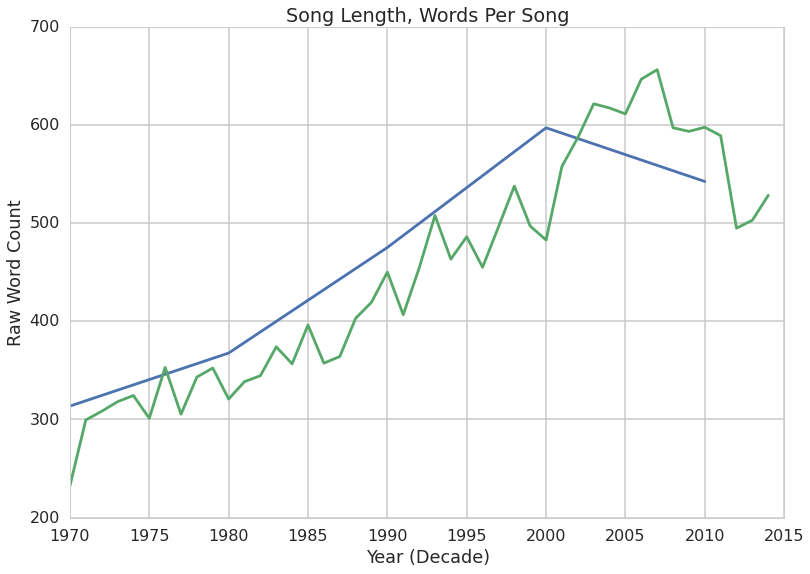

In [494]:
years=dfc.groupby('decade')
yearlexdiv= dict()
for year in years:
    yearlexdiv[year[0]]= year[1]['wordcount'].mean()
plotdict = collections.OrderedDict(sorted(yearlexdiv.items())) 
#plt.ylim([0,1])
plt.title("Song Length, Words Per Song")
plt.ylabel("Raw Word Count")
plt.xlabel("Year (Decade)")
x=plotdict.keys()
y=plotdict.values()
plt.plot(x,y)

years=dfc.groupby('year')
yearlexdiv= dict()
for year in years:
    yearlexdiv[year[0]]= year[1]['wordcount'].mean()
plotdict = collections.OrderedDict(sorted(yearlexdiv.items())) 
x=plotdict.keys()
y=plotdict.values()
plt.plot(x,y)

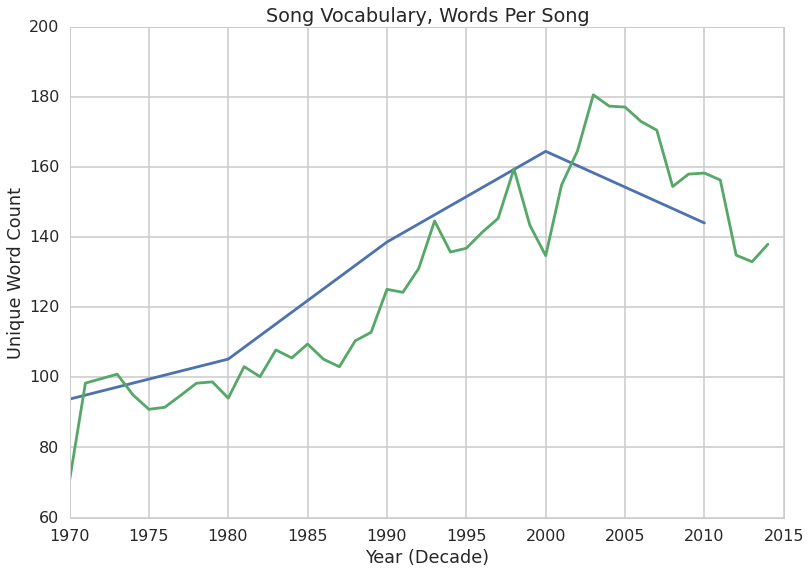

In [495]:
years=dfc.groupby('decade')
yearlexdiv= dict()
for year in years:
    yearlexdiv[year[0]]= year[1]['wordset'].mean()
plotdict = collections.OrderedDict(sorted(yearlexdiv.items())) 
#plt.ylim([0,1])
plt.title("Song Vocabulary, Words Per Song")
plt.ylabel("Unique Word Count")
plt.xlabel("Year (Decade)")
x=plotdict.keys()
y=plotdict.values()
plt.plot(x,y)

years=dfc.groupby('year')
yearlexdiv= dict()
for year in years:
    yearlexdiv[year[0]]= year[1]['wordset'].mean()
plotdict = collections.OrderedDict(sorted(yearlexdiv.items())) 
x=plotdict.keys()
y=plotdict.values()
plt.plot(x,y)

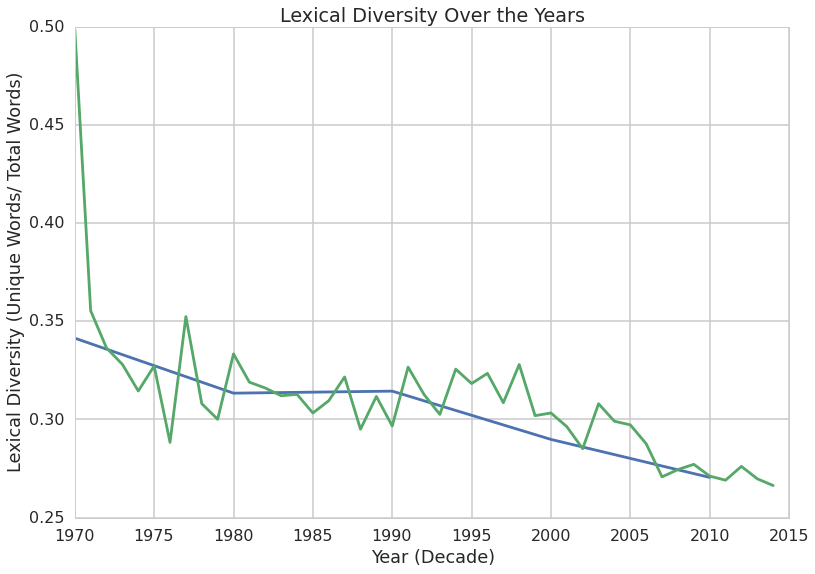

In [497]:
years=dfc.groupby('decade')
yearlexdiv= dict()
for year in years:
    yearlexdiv[year[0]]= year[1]['lexdiv'].mean()
plotdict = collections.OrderedDict(sorted(yearlexdiv.items())) 
#plt.ylim([0,1])
plt.title("Lexical Diversity Over the Years")
plt.ylabel("Lexical Diversity (Unique Words/ Total Words)")
plt.xlabel("Year (Decade)")
x=plotdict.keys()
y=plotdict.values()
plt.plot(x,y)

years=dfc.groupby('year')
yearlexdiv= dict()
for year in years:
    yearlexdiv[year[0]]= year[1]['lexdiv'].mean()
plotdict = collections.OrderedDict(sorted(yearlexdiv.items())) 
x=plotdict.keys()
y=plotdict.values()
plt.plot(x,y)


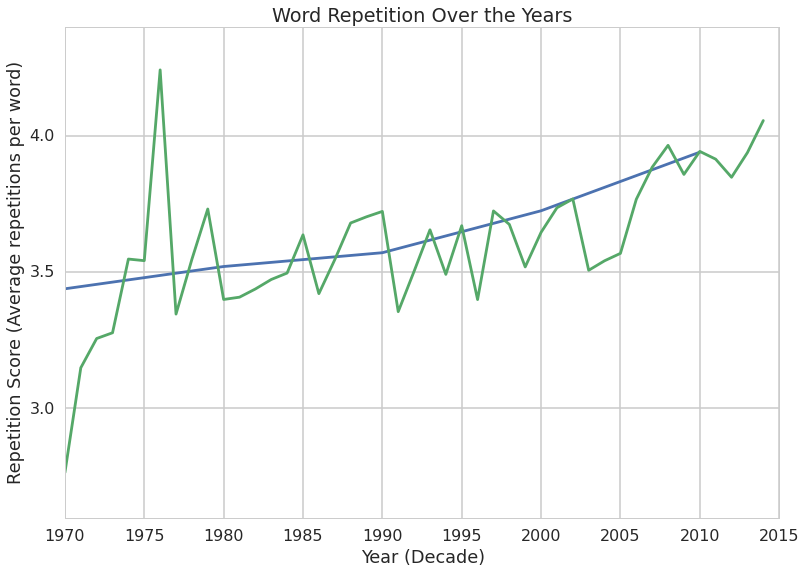

In [498]:
import collections
years=dfc.groupby('decade')
yearlexdiv= dict()
for year in years:
    yearlexdiv[year[0]]= year[1]['repetition_score'].mean()
plotdict = collections.OrderedDict(sorted(yearlexdiv.items())) 
#plt.ylim([0,1])
plt.title("Word Repetition Over the Years")
plt.ylabel("Repetition Score (Average repetitions per word)")
plt.xlabel("Year (Decade)")
x=plotdict.keys()
y=plotdict.values()
plt.plot(x,y)

years=dfc.groupby('year')
yearlexdiv= dict()
for year in years:
    yearlexdiv[year[0]]= year[1]['repetition_score'].mean()
plotdict = collections.OrderedDict(sorted(yearlexdiv.items())) 
x=plotdict.keys()
y=plotdict.values()
plt.plot(x,y)


In [429]:
dfc.sort(columns='repetition_score', inplace=True,ascending=False)
dfc.head(10)

,index,position,year,title.href,title,artist,lyrics,decade,song_key,lyrics_url,lyrics_abstract,lexdiv,repetition_score,wordcouunt,wordcount,wordset
2769,2769,70,1997,https://en.wikipedia.org/wiki/Tubthumping,Tubthumping,Chumbawamba,We'll be singing. When we're winning. We'll be...,1990,1997-70,http://lyrics.wikia.com/Chumbawamba:Tubthumping,We'll be singing. When we're winning. We'll be...,0.038808,25.767857,1443,1443,56
2834,2834,35,1998,https://en.wikipedia.org/wiki/Tubthumping,Tubthumping,Chumbawamba,We'll be singing. When we're winning. We'll be...,1990,1998-35,http://lyrics.wikia.com/Chumbawamba:Tubthumping,We'll be singing. When we're winning. We'll be...,0.038808,25.767857,1443,1443,56
692,692,93,1976,https://en.wikipedia.org/wiki/Give_Up_the_Funk...,Give Up the Funk (Tear the Roof off the Sucker),Parliament,". You've got a real type of thing going down, ...",1970,1976-93,http://lyrics.wikia.com/Parliament:Give_Up_The...,". You've got a real type of thing going down, ...",0.061117,16.362069,949,949,58
2575,2575,76,1995,https://en.wikipedia.org/wiki/Short_Dick_Man,Short Dick Man,20 Fingers,"Ah, ah. Ah, ah. Ah, ah, ah, ah. Ah, ah. Ah, ah...",1990,1995-76,http://lyrics.wikia.com/20_Fingers:Short_Dick_Man,"Ah, ah. Ah, ah. Ah, ah, ah, ah. Ah, ah. Ah, ah...",0.069201,14.450704,1026,1026,71
623,623,24,1976,https://en.wikipedia.org/wiki/Get_Up_and_Boogi...,Get Up and Boogie,Silver Convention,"(That's right). Get up and boogie, get up and ...",1970,1976-24,http://lyrics.wikia.com/Silver_Convention:Get_...,"(That's right). Get up and boogie, get up and ...",0.073864,13.538462,176,176,13
613,613,14,1976,"https://en.wikipedia.org/wiki/Fly,_Robin,_Fly","Fly, Robin, Fly",Silver Convention,"Fly, robin, fly. Fly, robin, fly. Fly, robin, ...",1970,1976-14,http://lyrics.wikia.com/Silver_Convention:Fly%...,"Fly, robin, fly. Fly, robin, fly. Fly, robin, ...",0.075758,13.200000,132,132,10
520,520,21,1975,https://en.wikipedia.org/wiki/The_Hustle_(song),The Hustle,Van McCoy,. Do it. Do it. Do it. Do the Hustle. Do the H...,1970,1975-21,http://lyrics.wikia.com/Van_McCoy:The_Hustle,. Do it. Do it. Do it. Do the Hustle. Do the H...,0.083333,12.000000,60,60,5
411,411,12,1974,https://en.wikipedia.org/wiki/Jungle_Boogie,Jungle Boogie,Kool and the Gang,"Get down, get down. Get down, get down. Get do...",1970,1974-12,http://lyrics.wikia.com/Kool_%26_The_Gang:Jung...,"Get down, get down. Get down, get down. Get do...",0.094218,10.613636,467,467,44
644,644,45,1976,https://en.wikipedia.org/wiki/That%27s_the_Way...,That's the Way (I Like It),KC and the Sunshine Band,Do do do do do do do do do. Do do do do do do ...,1970,1976-45,http://lyrics.wikia.com/KC_And_The_Sunshine_Ba...,Do do do do do do do do do. Do do do do do do ...,0.096838,10.326531,506,506,49
629,629,30,1976,https://en.wikipedia.org/wiki/Love_Rollercoaster,Love Rollercoaster,Ohio Players,"Rollercoaster, of love (Say what?). Rollercoas...",1970,1976-30,http://lyrics.wikia.com/Ohio_Players:Love_Roll...,"Rollercoaster, of love (Say what?). Rollercoas...",0.098465,10.155844,782,782,77


In [489]:
dfc.sort(columns='repetition_score', inplace=True,ascending=True)
dfc.head(10)

,index,position,year,title.href,title,artist,lyrics,decade,song_key,lyrics_url,lyrics_abstract,wordcount,wordset,lexdiv,repetition_score
63,63,64,1970,https://en.wikipedia.org/wiki/United_We_Stand_...,United We Stand,The Brotherhood of Man,bad,1970,1970-64,http://lyrics.wikia.com/Brotherhood_Of_Man:Uni...,There's nowhere in the world that I would rath...,1,1,1,1
33,33,34,1970,https://en.wikipedia.org/wiki/Instant_Karma!,Instant Karma!,John Lennon,bad,1970,1970-34,http://lyrics.wikia.com/John_Lennon:Instant_Ka...,Instant Karma's gonna get you. Gonna knock you...,1,1,1,1
32,32,33,1970,https://en.wikipedia.org/wiki/Venus_(Shocking_...,Venus,Shocking Blue,bad,1970,1970-33,http://lyrics.wikia.com/Shocking_Blue:Venus,A goddess on a mountain top. Was burning like ...,1,1,1,1
42,42,43,1970,https://en.wikipedia.org/wiki/Reflections_of_M...,Reflections of My Life,Marmalade,bad,1970,1970-43,http://lyrics.wikia.com/Marmalade:Reflections_...,The changing of sunlight to moonlight. Reflect...,1,1,1,1
102,102,3,1971,https://en.wikipedia.org/wiki/It%27s_Too_Late_...,It's Too Late,Carole King,bad,1970,1971-3,http://lyrics.wikia.com/Carole_King:It%27s_Too...,Stayed in bed all morning just to pass the tim...,1,1,1,1
85,85,86,1970,https://en.wikipedia.org/wiki/Gimme_Dat_Ding_(...,Gimme Dat Ding,The Pipkins,bad,1970,1970-86,http://lyrics.wikia.com/The_Pipkins:Gimme_Dat_...,"That's right, that's right, I'm sad and blue. ...",1,1,1,1
25,25,26,1970,NaN,Which Way You Goin' Billy?,The Poppy Family,bad,1970,1970-26,http://lyrics.wikia.com/The_Poppy_Family:Which...,Which Way You Goin' Billy? Poppy Family. Which...,1,1,1,1
46,46,47,1970,NaN,"Tighter, Tighter",Alive N Kickin',bad,1970,1970-47,http://lyrics.wikia.com/Alive_N_Kickin%27:Tigh...,You know I got to show you. Nobody else before...,1,1,1,1
47,47,48,1970,https://en.wikipedia.org/wiki/Come_and_Get_It_...,Come and Get It,Badfinger,bad,1970,1970-48,http://lyrics.wikia.com/Badfinger:Come_And_Get_It,"If you want it, here it is come and get it. Mm...",1,1,1,1
82,82,83,1970,https://en.wikipedia.org/wiki/Yellow_River_(song),Yellow River,Christie,bad,1970,1970-83,http://lyrics.wikia.com/Christie:Yellow_River,"So long, boy, you can take my place. I got my ...",1,1,1,1


In [ ]:
id2w=dict()
run = dict()
ntopics=4
for k in nounid2word:
    id2w[int(k)]=nounid2word[k]
# reduce the chunksize and make passes=2 since our data is not so big.
for i in range(1,ntopics):
    lda = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=id2w, num_topics=i+1, update_every=1, chunksize=100, passes=1)
    run[i+1]= lda.print_topics(num_topics=i+1,num_words=10)

In [4]:
for i in range(1,ntopics):
    print "\n Topics: ",i+1
    line=run[i+1]
    for j in range(0,i+1):
        print line[j]
        print "\n"


 Topics:  2
(0, u'0.035*love + 0.035*bitch + 0.031*time + 0.025*nigga + 0.024*hitta + 0.017*day + 0.016*diamond + 0.016*heart + 0.015*tonight + 0.013*eye')


(1, u'0.053*girl + 0.051*baby + 0.043*night + 0.033*thing + 0.023*life + 0.017*way + 0.017*shit + 0.016*hitta + 0.015*world + 0.015*kid')



 Topics:  3
(0, u'0.052*bitch + 0.035*life + 0.026*day + 0.025*heart + 0.023*world + 0.022*kid + 0.021*hitta + 0.020*eye + 0.020*boy + 0.019*somethin')


(1, u'0.077*girl + 0.051*love + 0.046*time + 0.036*nigga + 0.025*way + 0.024*shit + 0.022*tonight + 0.021*song + 0.018*hand + 0.018*hitta')


(2, u'0.078*baby + 0.066*night + 0.051*thing + 0.026*diamond + 0.021*hitta + 0.019*bass + 0.017*ya + 0.015*mind + 0.015*road + 0.013*problem')



 Topics:  4
(0, u'0.075*love + 0.075*bitch + 0.050*life + 0.035*heart + 0.027*hitta + 0.025*cause + 0.020*road + 0.018*problem + 0.016*money + 0.015*hoe')


(1, u'0.078*night + 0.060*thing + 0.031*hitta + 0.030*shit + 0.028*tonight + 0.027*world + 0.023*some

In [5]:
for bow in corpus[2:4400:440]:
    print bow
    print lda.get_document_topics(bow)
    print " ".join([id2w[e[0]] for e in bow])
    print "=========================================="

[(135, 1), (1887, 1)]
[(0, 0.086698481222652293), (1, 0.086112830731467888), (2, 0.086527538442594754), (3, 0.74066114960328511)]
water bridge
[(172, 1)]
[(0, 0.62499969085975016), (1, 0.12500009653921332), (2, 0.12500010339767423), (3, 0.12500010920336241)]
love
[(172, 1)]
[(0, 0.62499969086610618), (1, 0.12500009653488434), (2, 0.12500010339932421), (3, 0.12500010919968541)]
love
[(4602, 1)]
[(0, 0.12501259317356939), (1, 0.12501435583435536), (2, 0.12501258985084565), (3, 0.62496046114122961)]
river
[(3170, 1), (2606, 1)]
[(0, 0.086772286367330351), (1, 0.086179499950951213), (2, 0.7404161389174021), (3, 0.086632074764316266)]
junkyard dog
[(89, 1), (4028, 1), (1879, 1)]
[(0, 0.79724382043562969), (1, 0.06704159538901211), (2, 0.067833698004989174), (3, 0.067880886170369054)]
flu boogie pneumonia
[(3835, 1)]
[(0, 0.62499953582100221), (1, 0.12500014387595898), (2, 0.12500016089033555), (3, 0.12500015941270343)]
life
[(5070, 1)]
[(0, 0.12500521814319032), (1, 0.12500454217802454), (2

In [6]:
lsi = gensim.models.lsimodel.LsiModel(corpus=corpus, id2word=id2w, num_topics=40)

In [7]:
tlist = lsi.print_topics(10)
i=0
for t in tlist:
    i+=1
    print i,".  ",t, "\n"

1 .   -0.641*"love" + -0.469*"baby" + -0.280*"time" + -0.249*"girl" + -0.195*"way" + -0.154*"night" + -0.134*"heart" + -0.120*"thing" + -0.112*"ya" + -0.107*"life" 

2 .   0.582*"dance" + -0.549*"love" + 0.488*"baby" + 0.188*"body" + 0.183*"bop" + 0.101*"ya" + 0.099*"girl" + 0.081*"bump" + 0.059*"bow" + 0.049*"night" 

3 .   -0.740*"dance" + 0.437*"baby" + -0.386*"love" + -0.238*"bop" + 0.106*"girl" + 0.104*"body" + 0.087*"ya" + -0.076*"bow" + 0.054*"bump" + -0.038*"yowsah" 

4 .   -0.491*"girl" + 0.474*"baby" + -0.377*"time" + 0.315*"love" + -0.265*"way" + 0.149*"body" + -0.144*"thing" + -0.129*"day" + -0.128*"ya" + -0.125*"man" 

5 .   -0.849*"body" + -0.362*"bump" + 0.296*"baby" + -0.119*"girl" + -0.110*"yippie-yi-yo-yippie-yi-yea" + -0.074*"reer" + 0.066*"time" + -0.058*"night" + -0.053*"love" + 0.051*"ya" 

6 .   -0.713*"girl" + 0.550*"time" + 0.215*"night" + 0.166*"way" + -0.127*"love" + 0.125*"day" + 0.097*"body" + 0.089*"thing" + 0.087*"life" + 0.078*"heart" 

7 .   -0.791*"nig

In [8]:
adjvocab['delicious']

2102

In [10]:
#nhypes
